In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import json

# 접속 정보 로딩 (옵션: db-config.json 파일이 있을 경우)
path = './db-config.json'

with open(path) as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

# air_quality_dataset 테이블 데이터 읽어오기
query = "SELECT * FROM air_quality_dataset"
df = pd.read_sql(query, con=engine)

In [2]:
start_date = '2017-01-01'
end_date = '2023-12-31'

df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

In [3]:
meta_df = pd.DataFrame({'region': df['region'].unique()})

In [4]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Apple SD Gothic Neo'
matplotlib.rcParams['axes.unicode_minus'] = False

In [5]:
# def create_sequences(data, input_len, output_len):
#    X, y = [], []
#    for i in range(len(data) - input_len - output_len + 1):
#        X.append(data[i:i+input_len])
#        y.append(data[i+input_len:i+input_len+output_len])
#    return np.array(X), np.array(y)

def create_sequences(series, input_len=365, output_len=30):
    X, y = [], []
    for i in range(len(series) - input_len - output_len + 1):
        X.append(series[i: i+input_len])
        y.append(series[i+input_len: i+input_len+output_len].flatten())
    return np.array(X), np.array(y)

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

# region + datetime을 인덱스로 설정
df = df.set_index(['region', 'datetime'])

# 🔥 핵심: 지역별로 그룹을 유지한 채, 일자 기준 리샘플링
df = (
    df.groupby('region')
      .resample('1D', level='datetime')
      .max()
      .reset_index()
)

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping  # 추가

def train_lstm_models(data, meta_df, date_col, value_col,
                      input_len=40, output_len=10, train_ratio=0.8, epochs=50):
    models_dict = {}

    for _, row in meta_df.iterrows():
        region = row['region']

        # 데이터 준비
        ts_data = data[data['region'] == region].copy()
        ts_data[date_col] = pd.to_datetime(ts_data[date_col])
        ts_data = ts_data.sort_values(by=date_col).set_index(date_col)
        ts_data = ts_data[[value_col]].dropna()

        scaler = MinMaxScaler()
        # 정규화
        ts_data['pm10_scaled'] = scaler.fit_transform(ts_data[['pm10']])
        series = ts_data['pm10_scaled'].values.reshape(-1, 1)

        # 시퀀스 생성
        X, y = create_sequences(series, input_len, output_len)

        if len(X) == 0:
            print(f"[SKIP] {region}: 시퀀스 없음 (데이터 길이={len(series)})")
            continue

        split = int(len(X) * train_ratio)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # 모델 정의
        model = Sequential([
            Input(shape=(input_len, 1)),
            LSTM(128, activation='tanh', return_sequences=True),
            Dropout(0.2),
            LSTM(64, activation='tanh'),
            Dense(32, activation='relu'),
            Dense(30)
        ])


        model.compile(optimizer='adam', loss='mse')

        # EarlyStopping
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        # 학습
        model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stop],
            verbose=1
        )

        # 결과 저장
        models_dict[region] = {
            'model': model,
            'X_test': X_test,
            'y_test': y_test
        }

    return models_dict

In [8]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def evaluate_lstm_models(models_dict, value_col='값'):
    for region, content in models_dict.items():
        model = content['model']
        X_test = content['X_test']
        y_test = content['y_test']

        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
        print(f"[{region}] RMSE: {rmse:.2f}")

        plt.figure(figsize=(12, 6))
        plt.plot(y_test.flatten(), label='Actual', color='red')
        plt.plot(y_pred.flatten(), label='Predicted', color='green')
        plt.title(f"LSTM Forecast - {region} (RMSE={rmse:.2f})")
        plt.xlabel('Time Step')
        plt.ylabel(value_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [9]:
meta_df_yongsan = meta_df[meta_df['region'] == '용산구']

In [12]:
meta_df_yongsan.head()

,region
20,용산구


In [54]:
data = df
date_col='datetime'
value_col='pm10'
input_len=40
output_len=30
train_ratio=0.8

ts_data = data[data['region'] == '용산구'].copy()
ts_data[date_col] = pd.to_datetime(ts_data[date_col])
ts_data = ts_data.sort_values(by=date_col).set_index(date_col)
ts_data = ts_data[[value_col]].dropna()
series = ts_data[value_col].values.reshape(-1, 1)


In [60]:
len(ts_data)

2556

In [56]:
X, y = create_sequences(series, input_len, output_len)
if len(X) == 0:
    print(f"[SKIP] {region}: 시퀀스 없음 (데이터 길이={len(series)})")

split = int(len(X) * train_ratio)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [59]:
len(y_train)

1989

In [10]:
# 30일치 예측을 위한 학습
models_30day = train_lstm_models(
    data=df,
    meta_df=meta_df_yongsan,
    date_col='datetime',
    value_col='pm10',
    input_len=365,
    output_len=30,
    train_ratio=0.85,
    epochs=100
)

2025-07-03 12:49:13.313549: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-03 12:49:13.313616: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-07-03 12:49:13.313662: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-07-03 12:49:13.313714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-03 12:49:13.313738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-07-03 12:49:14.070393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
[용산구] RMSE: 0.05


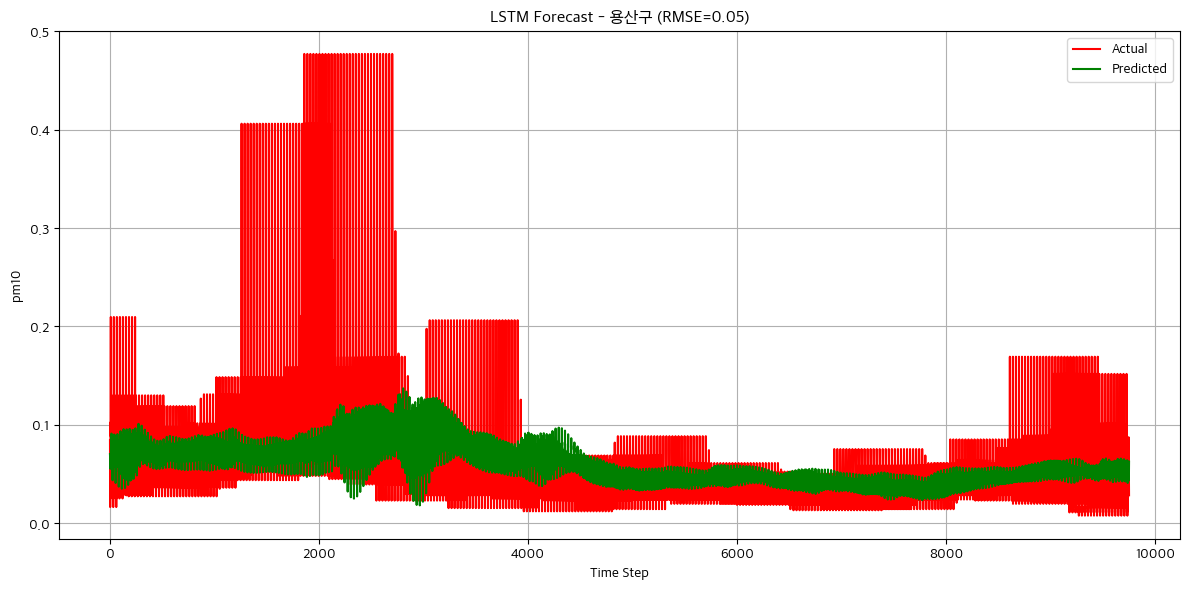

In [11]:
evaluate_lstm_models(models_30day, value_col='pm10')

In [102]:
def create_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len].flatten())
    return np.array(X), np.array(y)

In [103]:
def create_sequences(data, input_len, output_len=31):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len].flatten())
    return np.array(X), np.array(y)

def train_lstm_models(data, meta_df, date_col, value_col,
                      input_len=60, output_len=30, train_ratio=0.8, epochs=50):
    models_dict = {}

    for _, row in meta_df.iterrows():
        region = row['region']
        ts_data = data[data['region'] == region].copy()
        ts_data[date_col] = pd.to_datetime(ts_data[date_col])
        ts_data = ts_data.sort_values(by=date_col).set_index(date_col)
        ts_data = ts_data[[value_col]].dropna()

        # 로그 변환
        ts_data[value_col] = np.log1p(ts_data[value_col])
        series = ts_data[value_col].values.reshape(-1, 1)

        # 스케일링
        scaler = MinMaxScaler()
        series_scaled = scaler.fit_transform(series)

        # 시퀀스 생성
        X, y = create_sequences(series_scaled, input_len, output_len)
        if len(X) == 0:
            print(f"[SKIP] {region}: 시퀀스 없음")
            continue
        split = int(len(X) * train_ratio)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # 모델 정의
        model = Sequential([
            Input(shape=(input_len, 1)),
            LSTM(64, return_sequences=True),
            LSTM(32),
            Dense(32, activation='relu'),
            Dense(output_len)
        ])
        model.compile(optimizer='adam', loss='mse')

        # EarlyStopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # 학습
        model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=16,
            validation_split=0.1,
            callbacks=[early_stop],
            verbose=1
        )

        # 저장
        models_dict[region] = {
            'model': model,
            'X_test': X_test,
            'y_test': y_test,
            'scaler': scaler
        }

    return models_dict

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def plot_forecast_result(region, y_test, y_pred, scaler, output_len):
    # 역변환 (로그 + MinMaxScaler)
    y_test_inv = np.expm1(scaler.inverse_transform(y_test))
    y_pred_inv = np.expm1(scaler.inverse_transform(y_pred))

    # 30일치 예측은 타임스텝을 이어붙여서 flatten
    y_test_flat = y_test_inv.flatten()
    y_pred_flat = y_pred_inv.flatten()

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))

    # 시각화
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_flat, color='red', linewidth=1.5, label='Actual')
    plt.plot(y_pred_flat, color='green', linewidth=1.5, label='Predicted')
    plt.title(f"LSTM Forecast – {region} (RMSE={rmse:.2f})", fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("PM10")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [107]:
from sklearn.preprocessing import MinMaxScaler

In [108]:
# 30일치 예측을 위한 학습
models_30day = train_lstm_models(
    data=df,
    meta_df=meta_df_yongsan,
    date_col='datetime',
    value_col='pm10',
    input_len=40,
    output_len=30,
    train_ratio=0.8,
    epochs=100
)

Epoch 1/100


E0000 00:00:1751505355.070892 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0799 - val_loss: 0.0081
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0114 - val_loss: 0.0082
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0122 - val_loss: 0.0085
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0112 - val_loss: 0.0079
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0113 - val_loss: 0.0082
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0112 - val_loss: 0.0079
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0111 - val_loss: 0.0079
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0111 - val_loss: 0.0080
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0112 - val_loss: 0.0079
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 11/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0113 - val_loss: 0.0080


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
[용산구] RMSE: 40.42, MAE: 21.08, R²: 0.103


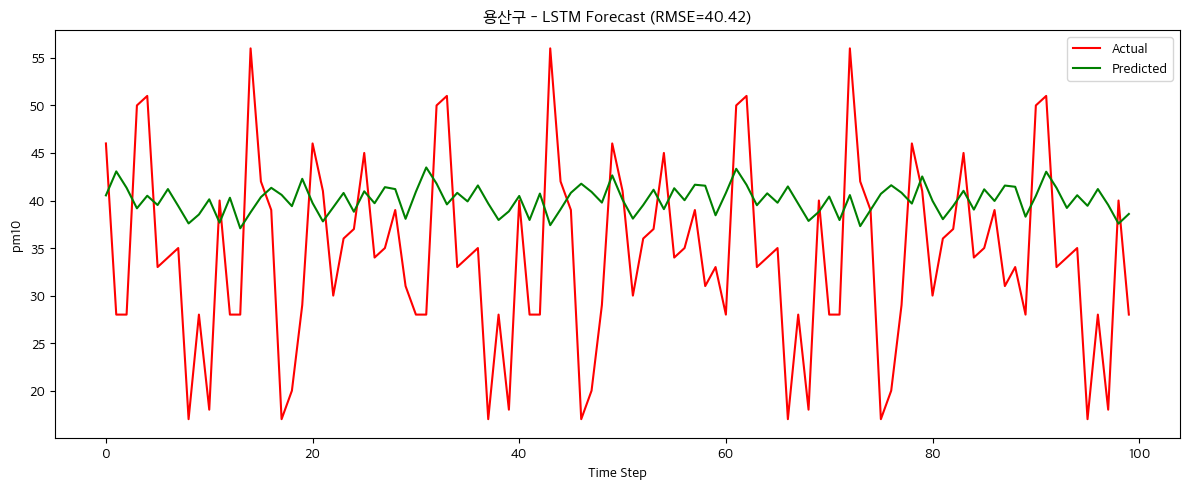

In [110]:
evaluate_lstm_models(models_30day, output_len=30, plot_sample_size=100)

In [111]:
#민석님코드

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import io
import h5py
import tempfile
from datetime import datetime

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from sqlalchemy import create_engine, MetaData, Table, Column
from sqlalchemy import Integer, String, Text, DateTime, LargeBinary
import json
from sqlalchemy import create_engine 
from sqlalchemy.exc import SQLAlchemyError
import cryptography

In [113]:
# 전처리 및 시퀀스 생성 함수
def create_sequences(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [124]:
def run_analysis(df):
    from datetime import timezone
    import tempfile
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    import numpy as np

    def create_sequences(data, window_size=48):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size])
            y.append(data[i + window_size, 0])
        return np.array(X), np.array(y)

    def lstm_forecast(series, region, pollutant):
        series = series.dropna().resample('D').mean().interpolate(method='spline', order=3).dropna()

        if len(series) < 100:
            print(f"[{region} - {pollutant}] 데이터 부족")
            return None, None

        df = pd.DataFrame(series)
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df)

        X, y = create_sequences(scaled, window_size=48)
        split = int(len(X) * 0.8)
        X_train, y_train = X[:split], y[:split]
        X_test, y_test = X[split:], y[split:]

        model = Sequential([
            Input(shape=(48, X.shape[2])),
            LSTM(64, return_sequences=True),
            LSTM(32),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

        y_pred = model.predict(X_test)
        y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), X.shape[2] - 1))]))[:, 0]
        y_pred_inv = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), X.shape[2] - 1))]))[:, 0]

        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

        plt.figure(figsize=(12, 4))
        plt.plot(y_test_inv[:100], label='Actual', linewidth=2)
        plt.plot(y_pred_inv[:100], label='Predicted', linewidth=2)
        plt.title(f"LSTM Forecast - {region} ({pollutant.upper()}) RMSE={rmse:.2f}")
        plt.legend()
        plt.grid()
        plt.show()

        return rmse, model

    # 분석 시작
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    #regions = df['region'].dropna().unique().tolist()
    regions = ['용산구']
    pollutants = ['pm10', 'pm25']

    for region in regions:
        df_region = df[df['region'] == region]
        for pollutant in pollutants:
            series = df_region[pollutant]
            print(f"\n▶ {region} - {pollutant.upper()} LSTM 예측")
            rmse, model = lstm_forecast(series, region, pollutant)
            if model is not None:
                print(f"→ 모델 학습 완료 (RMSE={rmse:.2f})")


▶ 용산구 - PM10 LSTM 예측
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


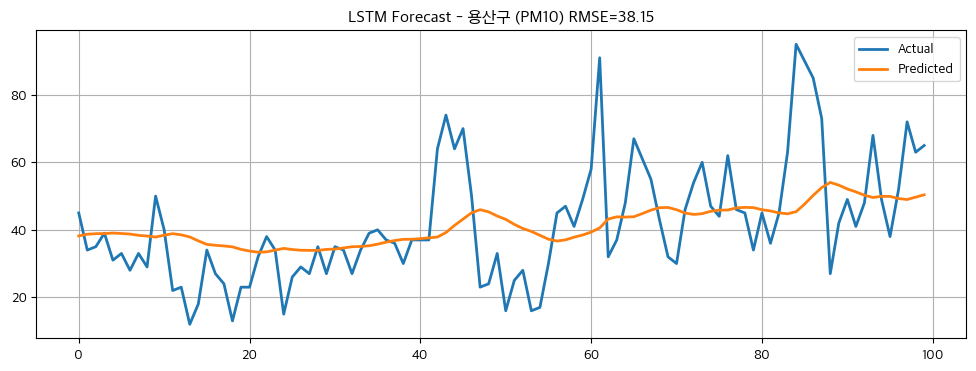

→ 모델 학습 완료 (RMSE=38.15)

▶ 용산구 - PM25 LSTM 예측


E0000 00:00:1751505900.841868 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


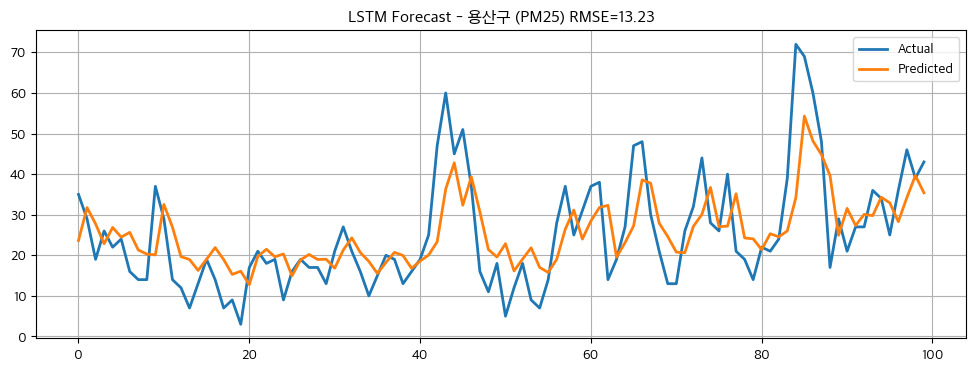

→ 모델 학습 완료 (RMSE=13.23)


In [125]:
run_analysis(df.copy())

In [126]:
def run_analysis(df):
    from datetime import timezone
    import tempfile
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error

    # 30일 예측용 시퀀스 생성 함수
    def create_sequences(data, input_len=60, output_len=30):
        X, y = [], []
        for i in range(len(data) - input_len - output_len):
            X.append(data[i:i + input_len])
            y.append(data[i + input_len : i + input_len + output_len, 0])
        return np.array(X), np.array(y)

    # LSTM 학습 및 예측 함수 (30일 예측)
    def lstm_forecast(series, region, pollutant):
        series = series.dropna().resample('D').mean().interpolate(method='spline', order=3).dropna()

        if len(series) < 120:
            print(f"[{region} - {pollutant}] 데이터 부족")
            return None, None

        df = pd.DataFrame(series)
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df)

        X, y = create_sequences(scaled, input_len=60, output_len=30)
        split = int(len(X) * 0.8)
        X_train, y_train = X[:split], y[:split]
        X_test, y_test = X[split:], y[split:]

        model = Sequential([
            Input(shape=(X.shape[1], 1)),
            LSTM(64, return_sequences=True),
            LSTM(32),
            Dense(30)
        ])
        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1,
                  callbacks=[early_stop], verbose=0)

        y_pred = model.predict(X_test)

        # 역변환 함수
        def inverse_transform(batch):
            return scaler.inverse_transform(np.hstack([batch, np.zeros((batch.shape[0], X.shape[2] - 1))]))[:, 0]

        y_test_inv = np.array([inverse_transform(y_test[:, i].reshape(-1, 1)) for i in range(30)]).T
        y_pred_inv = np.array([inverse_transform(y_pred[:, i].reshape(-1, 1)) for i in range(30)]).T

        rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))

        # 시각화: 마지막 예측 세트 기준 30일
        plt.figure(figsize=(12, 4))
        plt.plot(y_test_inv[-1], label='Actual (last)', linewidth=2)
        plt.plot(y_pred_inv[-1], label='Predicted (last)', linewidth=2)
        plt.title(f"LSTM Forecast - {region} ({pollutant.upper()}) 30일 예측 RMSE={rmse:.2f}")
        plt.legend()
        plt.grid()
        plt.show()

        return rmse, model

    # 분석 시작
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    regions = ['용산구']
    pollutants = ['pm10', 'pm25']

    for region in regions:
        df_region = df[df['region'] == region]
        for pollutant in pollutants:
            series = df_region[pollutant]
            print(f"\n▶ {region} - {pollutant.upper()} LSTM 30일 예측")
            rmse, model = lstm_forecast(series, region, pollutant)
            if model is not None:
                print(f"→ 모델 학습 완료 (RMSE={rmse:.2f})")



▶ 용산구 - PM10 LSTM 30일 예측


E0000 00:00:1751506000.532967 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


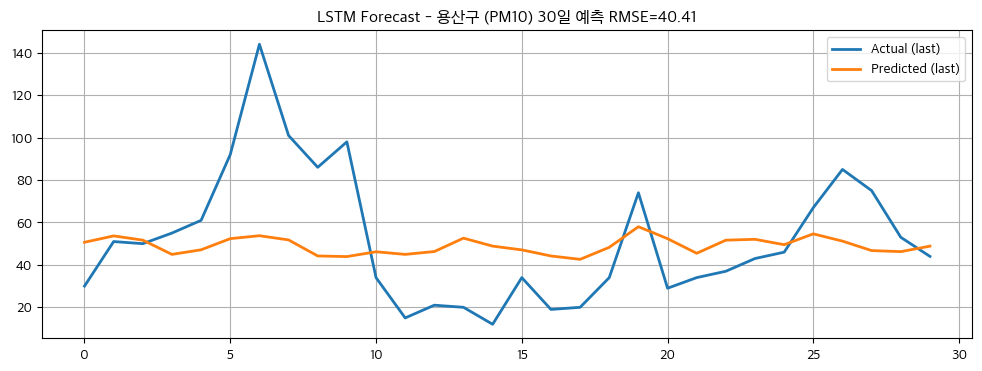

→ 모델 학습 완료 (RMSE=40.41)

▶ 용산구 - PM25 LSTM 30일 예측
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


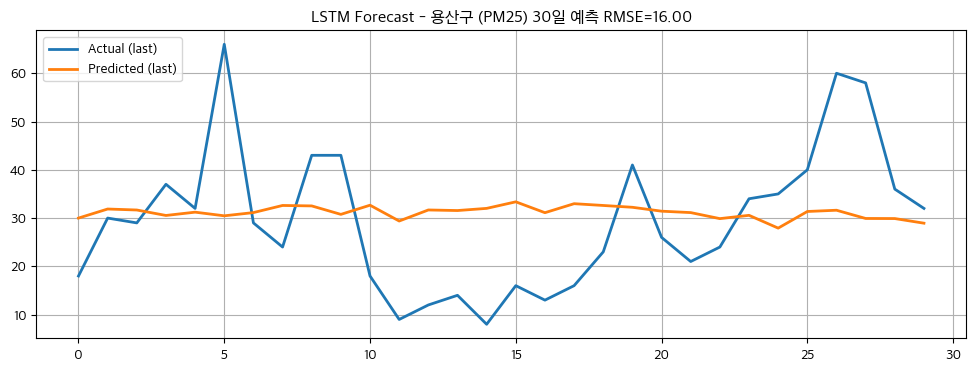

→ 모델 학습 완료 (RMSE=16.00)


In [127]:
run_analysis(df.copy())

In [128]:
#로그 변환 적용: np.log1p()
#클리핑: IQR 방식 (Q1 - 1.5×IQR ~ Q3 + 1.5×IQR)
#예측 후 np.expm1()로 역변환


▶ 용산구 - PM10 LSTM 30일 예측


E0000 00:00:1751506213.992449 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


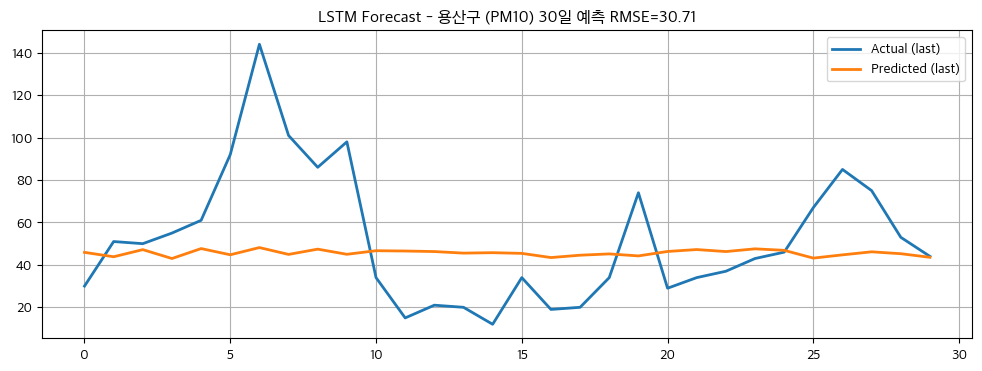

→ 모델 학습 완료 (RMSE=30.71)

▶ 용산구 - PM25 LSTM 30일 예측
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


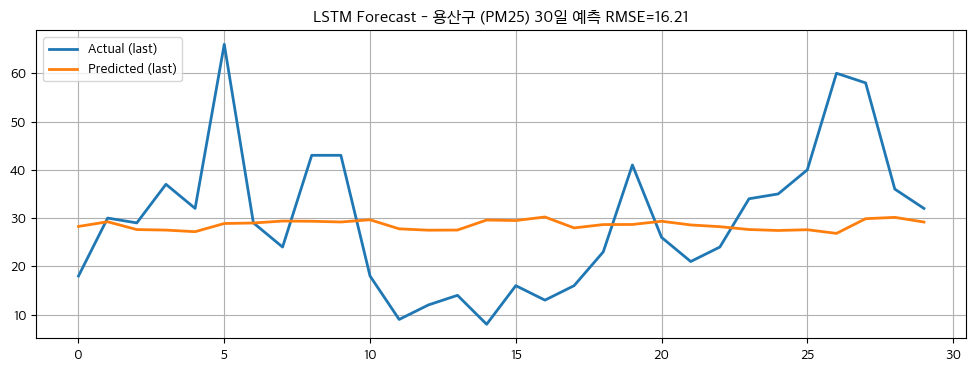

→ 모델 학습 완료 (RMSE=16.21)


In [130]:
run_analysis(df.copy())

In [138]:
def run_analysis(df):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error

    def create_sequences(X, y, input_len=60, output_len=30):
        Xs, ys = [], []
        for i in range(len(X) - input_len - output_len):
            Xs.append(X[i:i+input_len])
            ys.append(y[i+input_len:i+input_len+output_len])
        return np.array(Xs), np.array(ys)

    def remove_outliers_log(series):
        log_series = np.log1p(series)
        q1 = log_series.quantile(0.25)
        q3 = log_series.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        return log_series.clip(lower, upper)

    def lstm_forecast(df_region, region, target_col, feature_cols):
        df_region = df_region[['datetime'] + feature_cols + [target_col]].dropna()
        df_region = df_region.set_index('datetime').resample('D').mean().dropna()

        if len(df_region) < 120:
            print(f"[{region}] 데이터 부족")
            return None, None

        # 타겟만 로그변환 + 이상치 제거
        target_clipped_log = remove_outliers_log(df_region[target_col])

        # 결합
        df_model = df_region[feature_cols].copy()
        df_model[target_col] = target_clipped_log

        # 스케일링
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()

        X_scaled = feature_scaler.fit_transform(df_model[feature_cols])
        y_scaled = target_scaler.fit_transform(df_model[[target_col]]).flatten()

        X_seq, y_seq = create_sequences(X_scaled, y_scaled)

        split = int(len(X_seq) * 0.8)
        X_train, y_train = X_seq[:split], y_seq[:split]
        X_test, y_test = X_seq[split:], y_seq[split:]

        model = Sequential([
            Input(shape=(X_seq.shape[1], X_seq.shape[2])),
            LSTM(64, return_sequences=True),
            LSTM(32),
            Dense(30)
        ])
        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1,
                  callbacks=[early_stop], verbose=0)

        y_pred = model.predict(X_test)

        # 역변환: expm1(MinMax inverse)
        def inverse_transform(arr):
            inv_scaled = target_scaler.inverse_transform(arr)
            return np.expm1(inv_scaled)

        y_test_inv = inverse_transform(y_test)
        y_pred_inv = inverse_transform(y_pred)

        rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))

        plt.figure(figsize=(12, 4))
        plt.plot(y_test_inv[-1], label='Actual (last)', linewidth=2)
        plt.plot(y_pred_inv[-1], label='Predicted (last)', linewidth=2)
        plt.title(f"LSTM Forecast - {region} ({target_col.upper()}) 30일 예측 RMSE={rmse:.2f}")
        plt.legend()
        plt.grid()
        plt.show()

        return rmse, model

    # 분석 시작
    df['datetime'] = pd.to_datetime(df['datetime'])
    regions = ['용산구']
    target = 'pm10'
    feature_cols = ['wind_speed', 'precipitation', 'aod_avg']

    for region in regions:
        df_region = df[df['region'] == region].copy()
        print(f"\n▶ {region} - {target.upper()} 다변량 LSTM 30일 예측")
        rmse, model = lstm_forecast(df_region, region, target_col=target, feature_cols=feature_cols)
        if model is not None:
            print(f"→ 모델 학습 완료 (RMSE={rmse:.2f})")


▶ 용산구 - PM10 다변량 LSTM 30일 예측


E0000 00:00:1751506771.375307 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


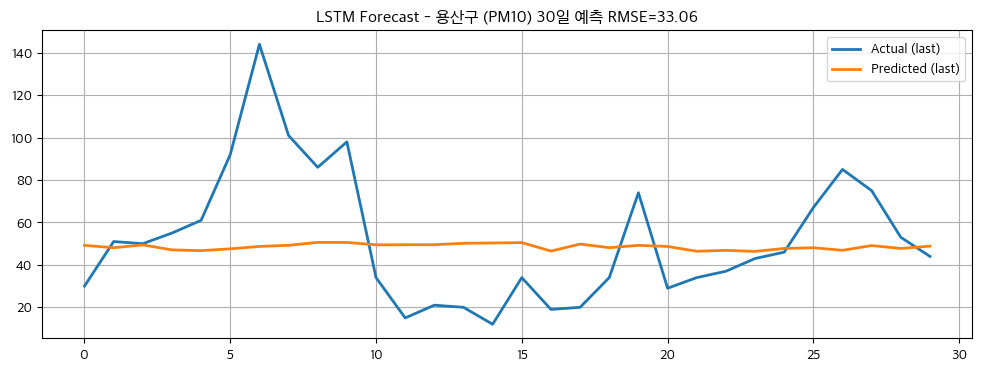

→ 모델 학습 완료 (RMSE=33.06)


In [139]:
run_analysis(df.copy())

In [140]:
'''
input_len = 90 / output_len = 30 으로 조정 (예측 대상: 30일)

LSTM 구조를 128 → 64로 확장

로그 변환 + 이상치 클리핑 + MinMaxScaler

성능 평가 지표 추가: RMSE, MAE, R²

시각화는 예측 마지막 구간(30일)에 대해 예측 vs 실제
'''

'\ninput_len = 90 / output_len = 30 으로 조정 (예측 대상: 30일)\n\nLSTM 구조를 128 → 64로 확장\n\n로그 변환 + 이상치 클리핑 + MinMaxScaler\n\n성능 평가 지표 추가: RMSE, MAE, R²\n\n시각화는 예측 마지막 구간(30일)에 대해 예측 vs 실제\n'

In [141]:
def run_analysis(df):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    def create_sequences(data, input_len=90, output_len=30):
        X, y = [], []
        for i in range(len(data) - input_len - output_len):
            X.append(data[i:i + input_len])
            y.append(data[i + input_len : i + input_len + output_len, 0])
        return np.array(X), np.array(y)

    def remove_outliers_log(series):
        log_series = np.log1p(series)
        q1, q3 = log_series.quantile(0.25), log_series.quantile(0.75)
        iqr = q3 - q1
        clipped = log_series.clip(q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        return clipped

    def lstm_forecast(series, region, pollutant):
        series = series.dropna().resample('D').mean().dropna()
        if len(series) < 150:
            print(f"[{region} - {pollutant}] 데이터 부족")
            return None, None, None, None

        series_clean = remove_outliers_log(series)
        df_scaled = pd.DataFrame(series_clean)
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df_scaled)

        X, y = create_sequences(scaled, 90, 30)
        split = int(len(X) * 0.8)
        X_train, y_train = X[:split], y[:split]
        X_test, y_test = X[split:], y[split:]

        model = Sequential([
            Input(shape=(X.shape[1], 1)),
            LSTM(128, return_sequences=True),
            LSTM(64),
            Dense(30)
        ])
        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=70, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

        y_pred = model.predict(X_test)

        def inverse_transform(arr):
            inv = scaler.inverse_transform(np.hstack([arr, np.zeros((arr.shape[0], X.shape[2] - 1))]))[:, 0]
            return np.expm1(inv)

        y_true = np.array([inverse_transform(y_test[:, i].reshape(-1, 1)) for i in range(30)]).T
        y_pred = np.array([inverse_transform(y_pred[:, i].reshape(-1, 1)) for i in range(30)]).T

        rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
        mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
        r2 = r2_score(y_true.flatten(), y_pred.flatten())

        # 시각화
        plt.figure(figsize=(12, 4))
        plt.plot(y_true[-1], label='Actual (last)', linewidth=2)
        plt.plot(y_pred[-1], label='Predicted (last)', linewidth=2)
        plt.title(f"LSTM Forecast - {region} ({pollutant.upper()}) 30일 예측\nRMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
        plt.legend()
        plt.grid()
        plt.show()

        return rmse, mae, r2, model

    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    regions = ['용산구']
    pollutants = ['pm10', 'pm25']
    results = []

    for region in regions:
        df_region = df[df['region'] == region]
        for pollutant in pollutants:
            series = df_region[pollutant]
            print(f"\n▶ {region} - {pollutant.upper()} LSTM 30일 예측")
            rmse, mae, r2, model = lstm_forecast(series, region, pollutant)
            if model:
                print(f"→ RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
                results.append((region, pollutant, rmse, mae, r2))

    return results


▶ 용산구 - PM10 LSTM 30일 예측


E0000 00:00:1751506986.206946 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


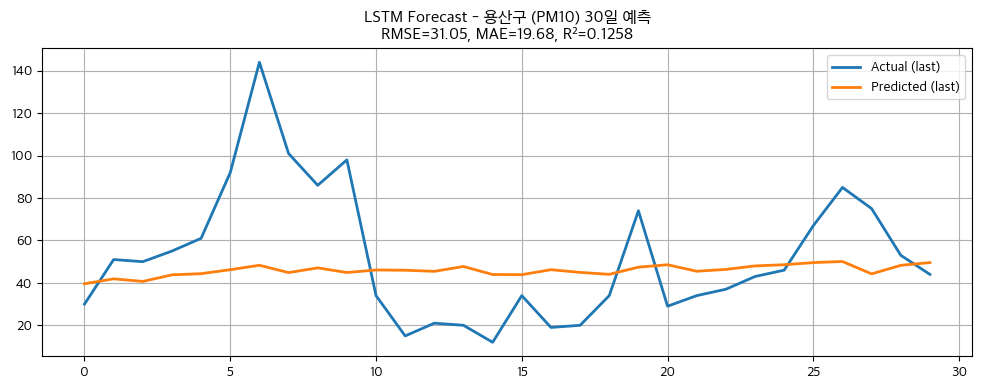

→ RMSE=31.05, MAE=19.68, R²=0.1258

▶ 용산구 - PM25 LSTM 30일 예측


E0000 00:00:1751507049.181797 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


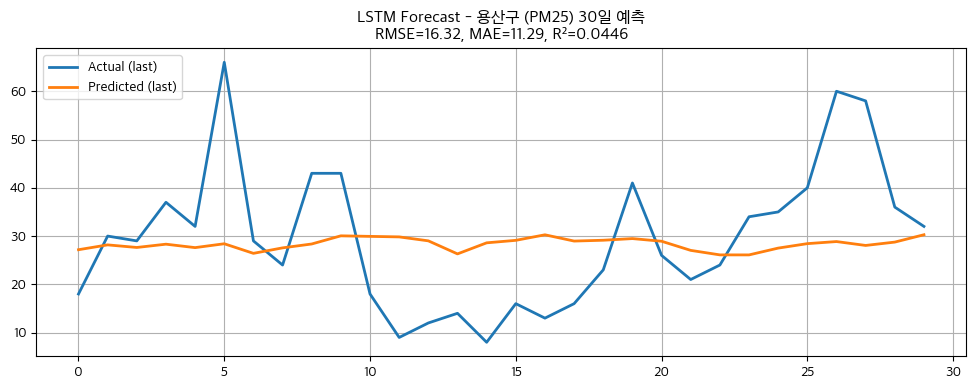

→ RMSE=16.32, MAE=11.29, R²=0.0446


[('용산구', 'pm10', 31.04700834595162, 19.68446615392025, 0.12580398681418647),
 ('용산구', 'pm25', 16.316110415269346, 11.288777747537031, 0.044643429013397795)]

In [142]:
run_analysis(df.copy())

In [143]:
#seq2seq 모델 - 장기예측 시계열에 적합

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

def create_seq2seq_data(data, input_len=90, output_len=30):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i + input_len])
        y.append(data[i + input_len : i + input_len + output_len])
    return np.array(X), np.array(y)

def remove_outliers_log(df_series):
    log_series = np.log1p(df_series)
    q1 = log_series.quantile(0.25)
    q3 = log_series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return log_series.clip(lower, upper)

def build_seq2seq_model(input_len, output_len, n_features):
    encoder_inputs = Input(shape=(input_len, n_features))
    _, state_h, state_c = LSTM(128, return_state=True)(encoder_inputs)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(output_len, n_features))
    decoder_lstm = LSTM(64, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = Dense(1)(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def run_seq2seq_forecast(df, region='용산구', pollutant='pm10', input_len=90, output_len=30):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    series = df[df['region'] == region][pollutant].dropna()
    series = series.resample('D').mean().dropna()

    if len(series) < input_len + output_len + 10:
        print(f"[{region} - {pollutant}] 데이터 부족")
        return

    series = remove_outliers_log(series)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(pd.DataFrame(series))

    X, y = create_seq2seq_data(scaled, input_len=input_len, output_len=output_len)
    y = y.reshape(y.shape[0], y.shape[1], 1)
    decoder_input = np.zeros_like(y)

    split = int(len(X) * 0.8)
    X_train, y_train, decoder_train = X[:split], y[:split], decoder_input[:split]
    X_test, y_test, decoder_test = X[split:], y[split:], decoder_input[split:]

    model = build_seq2seq_model(input_len, output_len, 1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit([X_train, decoder_train], y_train,
              validation_split=0.1,
              epochs=50,
              batch_size=32,
              callbacks=[early_stop],
              verbose=0)

    y_pred = model.predict([X_test, decoder_test])

    def inverse_transform(arr):
        return np.expm1(scaler.inverse_transform(arr.reshape(-1, 1))[:, 0])

    y_test_inv = np.array([inverse_transform(y_test[:, i, 0]) for i in range(output_len)]).T
    y_pred_inv = np.array([inverse_transform(y_pred[:, i, 0]) for i in range(output_len)]).T

    rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
    mae = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())
    r2 = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv[-1], label='Actual (last)', linewidth=2)
    plt.plot(y_pred_inv[-1], label='Predicted (last)', linewidth=2)
    plt.title(f"Seq2Seq Forecast - {region} ({pollutant.upper()}) 30일 예측\nRMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
    plt.legend()
    plt.grid()
    plt.show()

    return model



▶ 용산구 - PM10 LSTM 30일 예측


E0000 00:00:1751507218.211992 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


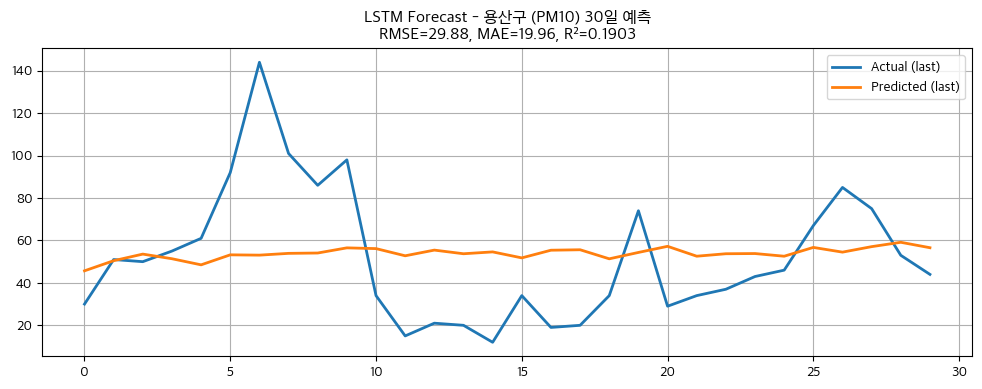

→ RMSE=29.88, MAE=19.96, R²=0.1903

▶ 용산구 - PM25 LSTM 30일 예측


E0000 00:00:1751507279.951224 24870825 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


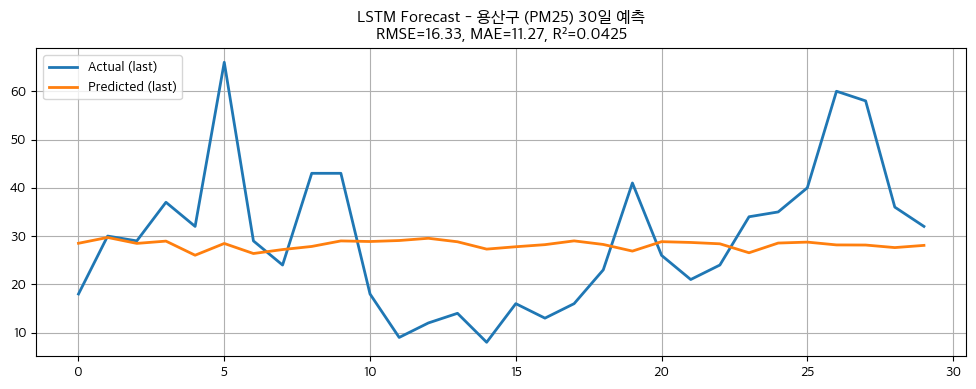

→ RMSE=16.33, MAE=11.27, R²=0.0425


[('용산구', 'pm10', 29.8794471976248, 19.962190254567247, 0.19031811801230425),
 ('용산구', 'pm25', 16.33399677850689, 11.27322324056296, 0.04254768187701119)]

In [145]:
run_analysis(df.copy())